# L'impact de la présence d'espaces verts sur l'appréciation de leur quartier par les résidents

## I- La localisation des espaces verts dans Paris

In [68]:
'''Thanks to the data retrieved from Paris OpenData and the geopandas library, we will analyse the location of green spaces in Paris'''
'''Importing packages'''
import pandas as pd
import geopandas as gpd
import numpy as np
import contextily as ctx
import matplotlib.pyplot as plt
from cartiflette.s3 import download_vectorfile_url_all

In [69]:
'''Let's download the geographical data of Paris to create its map'''
Paris_borders = download_vectorfile_url_all(
    crs = 2154, #Lambert 93
    values = ["75"],
    borders="COMMUNE_ARRONDISSEMENT",
    vectorfile_format="topojson",
    filter_by="DEPARTEMENT",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022)

https://minio.lab.sspcloud.fr/projet-cartiflette/diffusion/shapefiles-test1/year=2022/administrative_level=COMMUNE_ARRONDISSEMENT/crs=2154/DEPARTEMENT=75/vectorfile_format=topojson/provider=IGN/source=EXPRESS-COG-CARTO-TERRITOIRE/raw.topojson


Downloading: : 729iB [00:00, 2.27MiB/s]


HTTPError: HTTP Error 404: Not Found

### Aperçu du fichier recenssant les arrondissements de Paris et leurs coordonnées géorgraphiques:

In [70]:
Paris_borders.head()

,id,ID,NOM,NOM_M,INSEE_COM,STATUT,POPULATION,INSEE_CAN,INSEE_ARR,INSEE_DEP,INSEE_REG,SIREN_EPCI,source,INSEE_COG,geometry
0,ARR_MUNI0000000009736045,NaN,Paris 3e Arrondissement,PARIS 3E ARRONDISSEMENT,75056,Capitale d'état,34025,NR,1,75,11,200054781,IGN:EXPRESS-COG-CARTO-TERRITOIRE,75103,"POLYGON ((2.35016 48.86199, 2.35019 48.86203, ..."
1,ARR_MUNI0000000009736046,NaN,Paris 2e Arrondissement,PARIS 2E ARRONDISSEMENT,75056,Capitale d'état,21595,NR,1,75,11,200054781,IGN:EXPRESS-COG-CARTO-TERRITOIRE,75102,"POLYGON ((2.34792 48.87069, 2.34827 48.87062, ..."
2,ARR_MUNI0000000009736545,NaN,Paris 4e Arrondissement,PARIS 4E ARRONDISSEMENT,75056,Capitale d'état,29131,NR,1,75,11,200054781,IGN:EXPRESS-COG-CARTO-TERRITOIRE,75104,"POLYGON ((2.36849 48.85580, 2.36873 48.85482, ..."
3,ARR_MUNI0000000009736544,NaN,Paris 5e Arrondissement,PARIS 5E ARRONDISSEMENT,75056,Capitale d'état,58227,NR,1,75,11,200054781,IGN:EXPRESS-COG-CARTO-TERRITOIRE,75105,"POLYGON ((2.33666 48.83967, 2.33672 48.84011, ..."
4,ARR_MUNI0000000009736543,NaN,Paris 6e Arrondissement,PARIS 6E ARRONDISSEMENT,75056,Capitale d'état,40303,NR,1,75,11,200054781,IGN:EXPRESS-COG-CARTO-TERRITOIRE,75106,"POLYGON ((2.33292 48.85934, 2.33339 48.85924, ..."


### Aperçu du fichier recensant les espaces verts de Paris et leurs coordonnées géographiques :

In [80]:
espaces_verts=gpd.read_file("espaces_verts.geojson").to_crs(2154) #On convertit les données géographiques au même format que celles des arrondissements
espaces_verts=espaces_verts[espaces_verts["adresse_codepostal"].apply(lambda x:str(x).startswith("75"))]
espaces_verts.head()

,nsq_espace_vert,nom_ev,type_ev,categorie,adresse_numero,adresse_complement,adresse_typevoie,adresse_libellevoie,adresse_codepostal,poly_area,...,id_division,id_atelier_horticole,ida3d_enb,site_villes,id_eqpt,competence,geom,url_plan,geom_x_y,geometry
0,221.0,SQUARE FLORENCE BLUMENTHAL,Promenades ouvertes,Square,93.0,NaN,RUE DU,CHATEAU DES RENTIERS,75013,1900.0,...,113.0,163.0,52136,3057,3586,CA,NaN,http://p70-planet.apps.paris.mdp/Advitium/Appe...,NaN,"POLYGON ((653566.123 6858846.620, 653569.415 6..."
1,22.0,SQUARE HENRI GALLI,Promenades ouvertes,Square,9.0,NaN,BOULEVARD,HENRI IV,75004,2007.0,...,101.0,3.0,43332,1824,3610,CA,NaN,http://p70-planet.apps.paris.mdp/Advitium/Appe...,NaN,"POLYGON ((653154.640 6861481.308, 653155.008 6..."
2,744.0,SQUARE SEVERINE,Promenades ouvertes,Square,1.0,NaN,RUE,LE VAU,75020,23885.0,...,120.0,45.0,69327,3512,3698,CA,NaN,http://p70-planet.apps.paris.mdp/Advitium/Appe...,NaN,"POLYGON ((656805.535 6863062.691, 656806.521 6..."
3,669.0,SQUARE DU QUAI DE LA LOIRE,Promenades ouvertes,Square,31.0,NaN,QUAI DE LA,LOIRE,75019,1128.0,...,119.0,42.0,65690,1533,3569,CA,NaN,http://p70-planet.apps.paris.mdp/Advitium/Appe...,NaN,"POLYGON ((654252.356 6865321.278, 654260.456 6..."
4,11263.0,SQUARE AUGUSTE BALAGNY,Promenades ouvertes,Square,1.0,NaN,RUE,JEAN OESTREICHER,75017,2257.0,...,117.0,34.0,61342,4315,3326,CA,NaN,http://p70-planet.apps.paris.mdp/Advitium/Appe...,NaN,"MULTIPOLYGON (((647859.598 6865406.572, 647860..."


### Carte représentant la localisation des espaces verts dans les arrondissements de Paris:

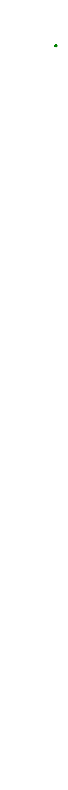

In [72]:
fig,ax = plt.subplots(figsize=(10,10))
espaces_verts.plot(ax=ax,alpha=0.8,edgecolor='green',facecolor='green')
Paris_borders.boundary.plot(ax = ax, edgecolor = "black", facecolor="none",color =None) #On affiche les bordures des arrondissements
ax.set_axis_off()

# II- Relation entre la surface verte et les notes de l'arrondissement

In [84]:
'''We group the green spaces data by arrondissement and compute the total green area'''
surface_verte= espaces_verts.groupby("adresse_codepostal")["surface_totale_reelle"].sum().to_frame().sort_values(by="surface_totale_reelle",ascending=False) #On somme et on trie dans l'ordre décroissant de la surface totale

### Classement des arrondissements selon la surface verte totale :

In [85]:
surface_verte

,surface_totale_reelle
adresse_codepostal,
75012,952968.0
75020,797930.0
75016,788740.0
75015,745832.0
75019,584801.0
75014,575442.0
75017,429355.0
75007,396466.0
75013,388920.0


In [106]:
notes_env=pd.read_excel("Notes_arrondissements.xlsx")["Environnement"].to_frame()

In [97]:
''We create a dictionary for the name of arrondissements to have the same nomenclatures in all tables'''
dict_arrondissements={}
for i in range(9):
    dict_arrondissements[i]='7500'+str(i+1)
for i in range(9,20):
    dict_arrondissements[i]='750'+str(i+1)

### Classement des arrondissements selon la note donnée au critère "Environnement" sur ville-ideale.fr :

In [107]:
notes_env=notes_env.rename(index= dict_arrondissements).sort_values(by="Environnement",ascending=False)
notes_env

,Environnement
75016,"7,38"
75005,"7,30"
75007,"6,88"
75012,"6,80"
75008,"6,78"
75006,"6,25"
75015,"6,20"
75017,"6,02"
75003,"5,52"
75019,"5,43"


### Classement des arrondissements selon la note globale donnée sur ville-ideale.fr :

In [103]:
notes_globales=pd.read_excel("Notes_arrondissements.xlsx")["Note Globale"].to_frame()

In [114]:
notes_globales=notes_globales.rename(index= dict_arrondissements).sort_values(by="Note Globale",ascending=False)
notes_globales

,Note Globale
75005,"8,32"
75008,"7,76"
75003,"7,65"
75006,"7,65"
75015,"7,49"
75012,"7,48"
75016,"7,38"
75007,"7,30"
75009,"7,25"
75017,"7,18"


### Jonction des trois tableaux :

In [117]:
tableau=pd.merge(surface_verte,notes_env.join(notes_globales),left_index=True,right_index=True).sort_index() #On merge tous les tableaux ensemble selon l'index(l'arrondissement)

In [118]:
tableau

,surface_totale_reelle,Environnement,Note Globale
75001,49979.0,"4,50","6,58"
75002,3485.0,"3,13","6,23"
75003,28342.0,"5,52","7,65"
75004,69836.0,"4,27","6,09"
75005,84995.0,"7,30","8,32"
75006,31441.0,"6,25","7,65"
75007,396466.0,"6,88","7,30"
75008,253567.0,"6,78","7,76"
75009,19645.0,"5,14","7,25"
75010,63637.0,"3,24","5,10"


### Représentation graphique :

<Axes: >

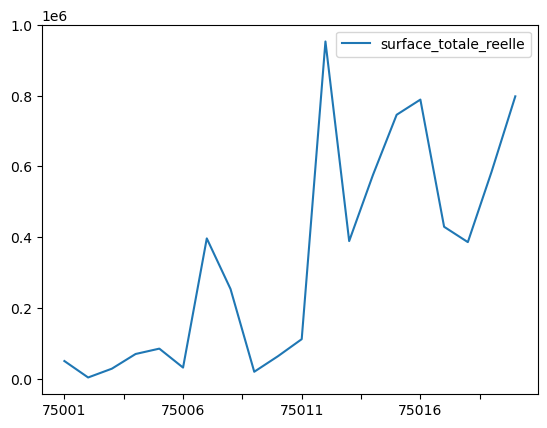

In [123]:
tableau.plot()